# 2D Annotations of Molecules 

## Introduction
The goal of this project is to render a 2 dimensional molecular drawing with annotations detailing a specific feature per atom. 

This example 

## Dependencies
1. IOData
2. Numpy
3. RDKit
4. Collections
5. CHEMML 
6. Pandas
7. Glob 
8. OS 


In [2]:
# import required libraries
from iodata import load_one, dump_one

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Atom
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import rdMolTransforms 
from rdkit.Chem import PeriodicTable
from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import DrawingOptions

from IPython.display import SVG
from IPython.display import Image

from collections import OrderedDict

from chemml.chem import Molecule

import pandas as pd

import glob
import os

## Manipulation of Input and Extraction of Charges 

We first want to open our file using IOData, designated `loadInput`, from then we can extract informations related to the `.fchk` file using IOData to annotate our molecule

In [3]:
inputName = 'dichloropyridine26_q+0.fchk'
loadInput = load_one(inputName) 

xyzName = 'dichloropyridine26_q+0.xyz'

molName = xyzName[:-4]


print("Molecule Name : ")
print(molName)
print(" ")



Molecule Name : 
dichloropyridine26_q+0
 


## Manipulate Molecule to Create MOL Object
We need to dump our IOData loaded molecule into an `.xyz` file, which can then be parsed using `CHEMML`, to create a data table containing basic information such as filename, XYZ Cartesian Coordinates, and the SMILES equivalent of the molecule.

We can then extract the SMILES string and convert into MOL Format for processing by RDKit. 

We can then use a series of commands `drawMolecule.*` to generate a visualization of our molecule. 

The below image is RDKit visualization without annotations. 

[<chemml.chem.Molecule(
        rdkit_molecule : <rdkit.Chem.rdchem.Mol object at 0x7fe1e27772b0>,
        pybel_molecule : <openbabel.pybel.Molecule object at 0x7fe1e2783550>,
        creator        : ('XYZ', 'dichloropyridine26_q+0.xyz'),
        smiles         : 'Clc1cccc(Cl)n1',
        smarts         : None,
        inchi          : None,
        xyz            : <XYZ(geometry: (11, 3), atomic_numbers: (11, 1), atomic_symbols: (11, 1))>)>]
 

                         Name          SMILES
0  dichloropyridine26_q+0.xyz  Clc1cccc(Cl)n1
 
Our Molecule in SMILES format: 
Clc1cccc(Cl)n1
 


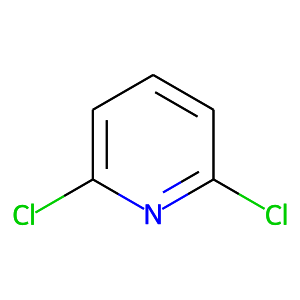

In [4]:
dump_one(loadInput,xyzName )
xyz_files = glob.glob(xyzName)

# make a list of ChemML Molecule object instances based on the names of the xyz files from xyz_files
molecule_list = [Molecule(xyzName, input_type='xyz') for file in xyz_files]

# alter the ChemML Molecule object instances of molecule_list so that their SMILES codes can be recognzied by RDKit
for molecule in molecule_list:
    molecule.to_smiles(kekuleSmiles=True)

print(molecule_list)

table = pd.DataFrame(data={'Name':xyzName,  
                         'SMILES':[molecule.smiles for molecule in molecule_list]}, 
                   columns=['Name','SMILES'])

print(" ")
print("")
print(table)

print(" ")
smiles = table.iloc[0,1]
print("Our Molecule in SMILES format: ")
print(smiles)
print(" ")

chem = Chem.MolFromSmiles(smiles)
chemc = Chem.Mol(chem.ToBinary())

drawMolecule = rdMolDraw2D.MolDraw2DCairo(300, 300)
rdMolDraw2D.PrepareAndDrawMolecule(drawMolecule, chemc)
drawMolecule.drawOptions().addStereoAnnotation = True
#drawMolecule.drawOptions().addAtomIndices = True
#drawMolecule.drawOptions().addBondIndices = True
drawMolecule.DrawMolecule(chemc)
drawMolecule.FinishDrawing()
png = drawMolecule.WriteDrawingText('molecule.png')
png

Image(filename="molecule.png")




In [77]:
symList =[]
atomList = []
chem2 = Chem.AddHs(chem)
for atom in chem2.GetAtoms():
    step = atom.GetSymbol(),atom.GetAtomicNum()
    symList.append(step)
    atomList.append(atom.GetSymbol())
print(symList)
print(atomList)

[('Cl', 17), ('C', 6), ('C', 6), ('C', 6), ('C', 6), ('C', 6), ('Cl', 17), ('N', 7), ('H', 1), ('H', 1), ('H', 1)]
['Cl', 'C', 'C', 'C', 'C', 'C', 'Cl', 'N', 'H', 'H', 'H']


## Annotations
We now want to retrieve IOData information, and add it to our visualization by appending the information to the MOL Object. 

In this context, we are outputting atomic number and electrostatic potential charges. 


IOData Retrieved Charges, Bulk :  
{'mulliken': array([-0.17984029, -0.17984725,  0.05002824, -0.04091242,  2.02394948,
        2.0239583 , -0.86473324, -0.86474131, -0.67554864, -0.64615815,
       -0.64615473]), 'esp': array([-0.11982276, -0.11982857, -0.53824353,  0.26057369, -0.45320065,
       -0.4532028 ,  0.49976881,  0.49977265,  0.0844758 ,  0.16985231,
        0.16985503]), 'npa': array([ 0.01191899,  0.01191245, -0.49012581, -0.1689309 , -0.27573862,
       -0.2757388 ,  0.21524212,  0.21524428,  0.24472353,  0.25574567,
        0.25574709])}
 
IOData Retrieved Atomic Numbers : 
[17, 17, 7, 6, 6, 6, 6, 6, 1, 1, 1]
 
 IOData Retrieved ESP Charges : 
[-0.11982276 -0.11982857 -0.53824353  0.26057369 -0.45320065 -0.4532028
  0.49976881  0.49977265  0.0844758   0.16985231  0.16985503]
 
STEST
[('H', 0.169855031)]


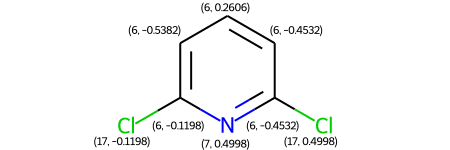

In [78]:
chem2 = chem


numbers = np.ndarray.tolist(loadInput.atnums)
print("IOData Retrieved Charges, Bulk :  ")
chargeDict = (loadInput.atcharges)
print(chargeDict)

espCharges = (chargeDict['esp'][:])
print(" ")
print("IOData Retrieved Atomic Numbers : ")
print(numbers)

print(" ")
print(" IOData Retrieved ESP Charges : ")
print(espCharges)
print(" ")
dict = []
print("STEST")
for i in range(0,len(numbers)):
    step = numbers[i],espCharges[i]
    dict.append(step)

test = []


def function(test):
    if symList[i][1] == dict[i][0]:
        step = atomList[i],dict[i][1]
        test.append(step)
function(test)
print(test)
for i, atom in enumerate(chem2.GetAtoms()):
    atom.SetProp("atomNote", f"{symList[i][1],np.round(float(espCharges[i]),4)}")

chem2




In [9]:
for i,atom in enumerate(chem2.GetAtoms()):
   print(atom.GetSymbol(), atom.GetAtomicNum(), espCharges[i])


Cl 17 -0.119822758
C 6 -0.119828567
C 6 -0.538243531
C 6 0.260573695
C 6 -0.453200648
C 6 -0.4532028
Cl 17 0.499768812
N 7 0.499772652


In [7]:
'''

for item in loadInput.atcharges["esp"]:
    key = loadInput.atnums
    listCharge = item
    print(listCharge)
    
for number in loadInput.atnums: 
    print(number)
    

q = pd.DataFrame.from_dict(loadInput.atcharges.items())
print("Atomic Charges : ")
print(q)
print(" ")

espCharges = q.iloc[1,1]
print("Charges, ESP : ")
print(espCharges)
print(" ")

atomicNumbers = loadInput.atnums
print("Atomic Numbers : ")
print(atomicNumbers)
'''

'''
listAtomicNumbers = np.ndarray.tolist(atomicNumbers)
print(listAtomicNumbers)

listChargesESP = np.ndarray.tolist(espCharges)
print(listChargesESP)

atomChargeDict = {}

for key in listAtomicNumbers: 
    for value in listChargesESP: 
        atomChargeDict[key] = np.round(float(value),4)
        listChargesESP.remove(value)
        break
print(atomChargeDict)
'''


'\nlistAtomicNumbers = np.ndarray.tolist(atomicNumbers)\nprint(listAtomicNumbers)\n\nlistChargesESP = np.ndarray.tolist(espCharges)\nprint(listChargesESP)\n\natomChargeDict = {}\n\nfor key in listAtomicNumbers: \n    for value in listChargesESP: \n        atomChargeDict[key] = np.round(float(value),4)\n        listChargesESP.remove(value)\n        break\nprint(atomChargeDict)\n'